In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import sympy 
from sympy import banded, ones, Matrix, symbols, sqrt, print_latex, oo
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import wofz 
import pickle

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Legendre Linear Response Function

In [4]:
# number of moments
Nv = 3

In [5]:
# symbolic variables
v, zeta = symbols('v zeta') 
k = symbols('k', integer = True)

In [6]:
def legendre(xi, n):
    if n<0:
        return 0
    elif n==0:
        return 1
    elif n==1:
        return xi
    else:
        return ((2*n-1)*xi*legendre(xi=xi, n=n-1) - (n-1)*legendre(xi=xi, n=n-2))/n

In [7]:
# velocity boundaries
vb = 5
va = -5

In [8]:
vec_mu = sympy.zeros(Nv)

for ii in range(0, Nv):
    beta = sympy.sqrt(2*ii + 1) * legendre(xi=(2*v -(vb+va))/(vb-va), n=ii)
    vec_mu[ii] = sympy.integrate(beta*sympy.exp(-(v**2)/2)*v, (v, va, vb))/(sympy.sqrt(sympy.pi)*2)

In [9]:
sympy.simplify(vec_mu[0, :])

Matrix([[0, -sqrt(3)*exp(-25/2)/sqrt(pi) + sqrt(6)*erf(5*sqrt(2)/2)/10, 0]])

In [10]:
vec_off = sympy.zeros(Nv)
vec_main = sympy.zeros(Nv)
for jj in range(1, Nv+1):
    vec_off[jj-1] = (sympy.Rational(vb - va, 2) * (jj/sympy.sqrt((2*jj+1)*(2*jj-1)))) / sympy.sqrt(2)
    vec_main[jj-1] = sympy.Rational(va + vb, 2) / sympy.sqrt(2)

In [11]:
vec_off[0, :]

Matrix([[5*sqrt(6)/6, sqrt(30)/3, 3*sqrt(70)/14]])

In [12]:
vec_main[0, :]

Matrix([[0, 0, 0]])

In [13]:
A = banded({1: tuple(vec_off[0, :-1]), -1: tuple(vec_off[0, :-1]), 0:tuple(vec_main[0, :])})

In [14]:
A

Matrix([
[          0, 5*sqrt(6)/6,          0],
[5*sqrt(6)/6,           0, sqrt(30)/3],
[          0,  sqrt(30)/3,          0]])

In [15]:
I = np.eye(Nv, dtype=int)

In [16]:
M = sympy.Matrix(I*zeta -k/np.abs(k)* A)

In [17]:
R_approx = sympy.simplify((M.inv().multiply(vec_mu[0, :].T))[0] * k / np.abs(k))
R_approx 

(-5*sqrt(2) + sqrt(pi)*exp(25/2)*erf(5*sqrt(2)/2))*exp(-25/2)/(sqrt(pi)*(2*zeta**2 - 15))

In [18]:
# latex code
print_latex(R_approx)

\frac{- 5 \sqrt{2} + \sqrt{\pi} e^{\frac{25}{2}} \operatorname{erf}{\left(\frac{5 \sqrt{2}}{2} \right)}}{\sqrt{\pi} \left(2 \zeta^{2} - 15\right) e^{\frac{25}{2}}}


In [19]:
with open("legendre_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(R_approx, outf)

## Asymptotic Expansion

### Adiabatic limit $\xi \to 0$

In [20]:
asymptotics_0 = R_approx.series(zeta, 0, 2)

In [21]:
asymptotics_0

sqrt(2)*exp(-25/2)/(3*sqrt(pi)) - erf(5*sqrt(2)/2)/15 + O(zeta**2)

In [22]:
print_latex(asymptotics_0)

\frac{\sqrt{2}}{3 \sqrt{\pi} e^{\frac{25}{2}}} - \frac{\operatorname{erf}{\left(\frac{5 \sqrt{2}}{2} \right)}}{15} + O\left(\zeta^{2}\right)


### Fluid (cold plasma) limit $\xi \to \infty$

In [23]:
asymptotics_inf = R_approx.series(zeta, oo, 4)

In [24]:
asymptotics_inf

(-5*sqrt(2)*exp(-25/2)/(2*sqrt(pi)) + erf(5*sqrt(2)/2)/2)/zeta**2 + O(zeta**(-4), (zeta, oo))

In [25]:
print_latex(asymptotics_inf)

\frac{- \frac{5 \sqrt{2}}{2 \sqrt{\pi} e^{\frac{25}{2}}} + \frac{\operatorname{erf}{\left(\frac{5 \sqrt{2}}{2} \right)}}{2}}{\zeta^{2}} + O\left(\frac{1}{\zeta^{4}}; \zeta\rightarrow \infty\right)


## Comparison with Hammett-Perkins 1990's approximation

In [26]:
def Z_fun(z):
    return 1j*np.sqrt(np.pi)*wofz(z)

def R(xi):
    return -(1 + xi*Z_fun(xi))

def RHP3(xi):
    return (1j*xi -2/np.sqrt(np.pi))/(2/np.sqrt(np.pi) - 1j*3*xi - (4/np.sqrt(np.pi))*(xi**2) + 2j*(xi**3))

def RHP4(xi):
    return (-4 +2j*np.sqrt(np.pi)*xi + (3*np.pi -8)*(xi**2))/(4 - 6j*np.sqrt(np.pi)*xi - (9*np.pi -16)*(xi**2) + 4j*np.sqrt(np.pi)* (xi**3) + 2*(3*np.pi - 8)*(xi**4))

def R3(xi):
    with open('legendre_3.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

def R4(xi):
    with open('legendre_4.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

def R5(xi):
    with open('legendre_5.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

def R6(xi):
    with open('legendre_6.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

In [27]:
xi = 10**np.linspace(-2, 2, int(1e5))

In [28]:
R_HP3 = RHP3(xi)
R_HP4 = RHP4(xi)
R_3 = R3(xi)
R_4 = R4(xi)
R_5 = R5(xi)
R_6 = R6(xi)
R_true = R(xi)

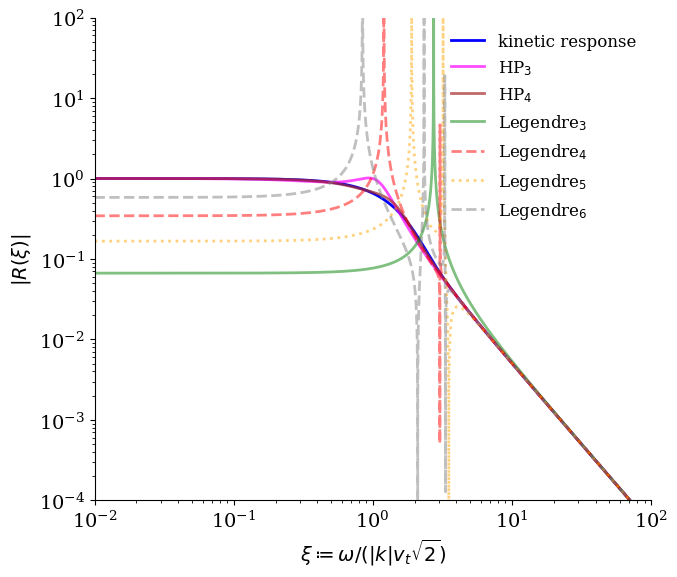

In [29]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(xi, np.abs(R_true), label=r"kinetic response", c="blue", linewidth=2)
ax.plot(xi, np.abs(R_HP3), label=r"HP$_{3}$", c="magenta", linewidth=2, alpha=0.7)
ax.plot(xi, np.abs(R_HP4), label=r"HP$_{4}$", c="brown", linewidth=2, alpha=0.7)
ax.plot(xi, np.abs(R_3), label=r"Legendre$_{3}$", c="green", ls="-", linewidth=2, alpha=0.5)
ax.plot(xi, np.abs(R_4), label=r"Legendre$_{4}$", c="red", ls="--", linewidth=2, alpha=0.5)
ax.plot(xi, np.abs(R_5), label=r"Legendre$_{5}$", c="orange", ls=":", linewidth=2, alpha=0.5)
ax.plot(xi, np.abs(R_6), label=r"Legendre$_{6}$", c="grey", ls="--", linewidth=2, alpha=0.5)
ax.set_ylim(10**-4, 10**2)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|R(\xi)|$")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/symbolic_response_function_Legendre.png", dpi=300)

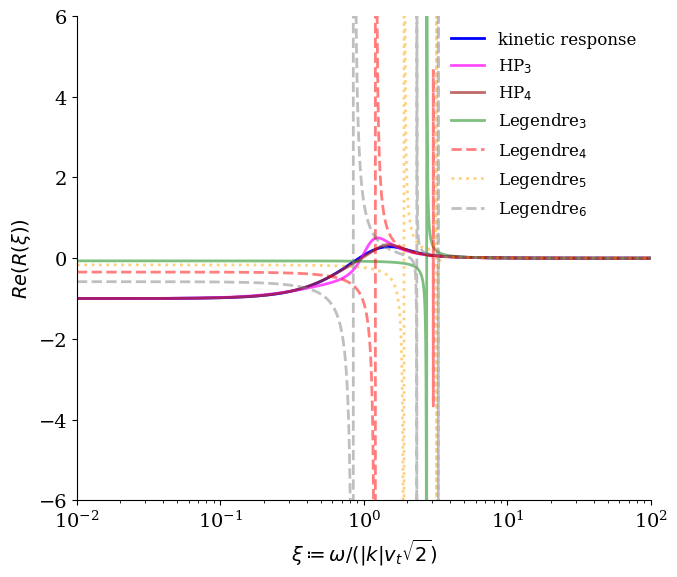

In [30]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(xi, np.real(R_true), label=r"kinetic response", c="blue", linewidth=2)
ax.plot(xi, np.real(R_HP3), label=r"HP$_{3}$", c="magenta", linewidth=2, alpha=0.7)
ax.plot(xi, np.real(R_HP4), label=r"HP$_{4}$", c="brown", linewidth=2, alpha=0.7)
ax.plot(xi, np.real(R_3), label=r"Legendre$_{3}$", c="green", ls="-", linewidth=2, alpha=0.5)
ax.plot(xi, np.real(R_4), label=r"Legendre$_{4}$", c="red", ls="--", linewidth=2, alpha=0.5)
ax.plot(xi, np.real(R_5), label=r"Legendre$_{5}$", c="orange", ls=":", linewidth=2, alpha=0.5)
ax.plot(xi, np.real(R_6), label=r"Legendre$_{6}$", c="grey", ls="--", linewidth=2, alpha=0.5)

ax.set_ylim(-6, 6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$Re(R(\xi))$")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()

plt.savefig("figs/symbolic_response_function_real_Legendre.png", dpi=300)

## Poles of the response function

In [31]:
n,d = sympy.fraction(R3(zeta))
d

3.54490770181103*zeta**2 - 26.5868077635827

In [32]:
sympy.roots(d)

{-2.73861278752583: 1, 2.73861278752583: 1}

## Analytic Response function

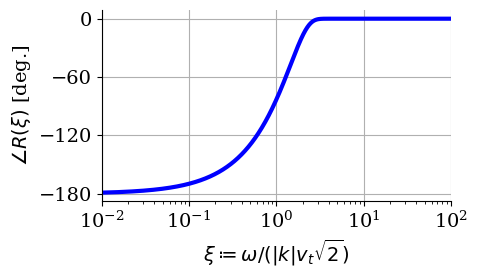

In [33]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(xi, np.angle(R_true, deg=True), linewidth=3, color="blue")
ax.set_xscale("log")
ax.set_ylabel(r"$\angle R(\xi)$ [deg.]")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xlim(1e-2, 1e2)
ax.set_yticks([0, -60, -120, -180])
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/angle.png", dpi=300)

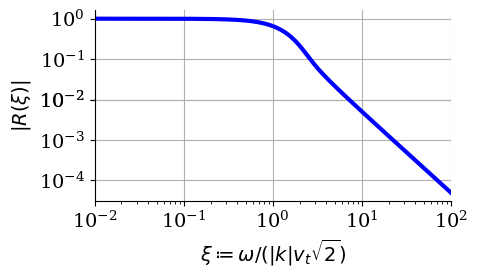

In [34]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(xi, np.abs(R_true), linewidth=3, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"$|R(\xi)|$")
ax.set_yticks([1, 1e-1, 1e-2, 1e-2, 1e-3, 1e-4])
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xlim(1e-2, 1e2)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/magnitude.png", dpi=300)

## Landau Damping dispersion relation

In [35]:
def get_landau_dispersion(func, xi_real, xi_imag, tol=1e-5):
    # initialize vectors 
    k_ = np.zeros(len(xi_real))*np.nan
    gr_ = np.zeros(len(xi_real))*np.nan
    # loop over to find minima
    for ii, xr in enumerate(xi_real):
        r_ = func(xi=xr + 1j*xi_imag) 
        if np.min(np.abs(np.imag(r_))) < tol:
            gr_[ii] = xi_imag[np.nanargmin(np.abs(r_.imag))]
            if r_[np.nanargmin(np.abs(np.imag(r_)))].real>=0:
                k_[ii] = np.sqrt(r_[np.nanargmin(np.abs(r_.imag))].real)
    return gr_[np.argsort(k_)], k_[np.argsort(k_)]

In [36]:
gr_true, k_true = get_landau_dispersion(func=R, xi_real=np.linspace(0, 5, int(1e4)), xi_imag=np.linspace(-1, 0, int(1e4)))

In [37]:
gr_hp3, k_hp3 = get_landau_dispersion(func=RHP3, xi_real=np.linspace(0, 7, int(1e4)), xi_imag=np.linspace(-0.8, 0, int(1e4)))

In [38]:
gr_hp4, k_hp4 = get_landau_dispersion(func=RHP4, xi_real=np.linspace(0, 6, int(1e4)), xi_imag=np.linspace(-0.75, 0, int(1e4)))

In [39]:
gr_l6, k_l6 = get_landau_dispersion(func=R6, xi_real=np.linspace(0, 6, int(1e3)), xi_imag=np.linspace(-0.75, 0, int(1e3)))

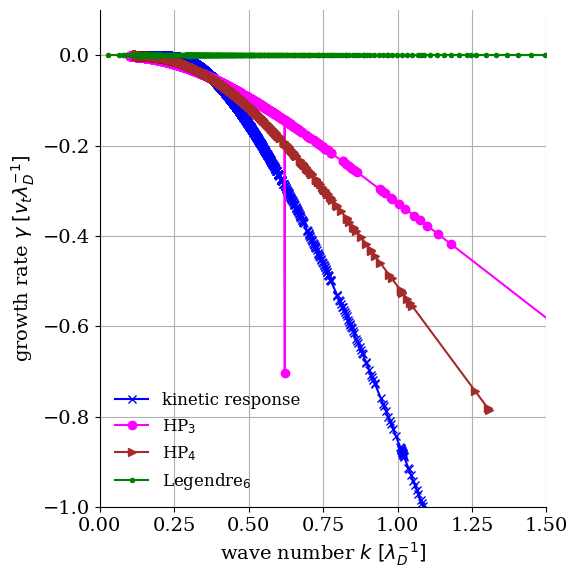

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"HP$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"HP$_{4}$", c="brown", marker=">")
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6, label=r"Legendre$_{6}$", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-1, 0.1)
ax.set_xlim(0, 1.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/landau_damping_hp.png", dpi=300)

## Two-Stream dispersion relation

In [41]:
T = 1/(2*np.sqrt(2))

In [42]:
# Despersion relation
def disp_k_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*R(xi=((xi-u2)/T))/(T**2) - (1-n1)*R(xi=((xi-u1)/T))/(T**2)

# Despersion relation
def disp_k_hp3_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*RHP3(xi=(xi-u2)/T)/(T**2) - (1-n1)*RHP3(xi=(xi-u1)/T)/(T**2)

# Despersion relation
def disp_k_hp4_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*RHP4(xi=(xi-u2)/T)/(T**2) -(1-n1)*RHP4(xi=(xi-u1)/T)/(T**2)

# Despersion relation
def disp_k_6_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*R6(xi=(xi-u2)/T)/(T**2) + -(1-n1)*R6(xi=(xi-u1)/T)/(T**2)

In [43]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(1E-2, 4, int(1e4)), xi_imag=np.linspace(0.001, 3, int(1e4)), tol=1e-4)

In [44]:
gr_hp3, k_hp3 = get_landau_dispersion(func=disp_k_hp3_bot, xi_real=np.linspace(0, 4, int(1e4)), xi_imag=np.linspace(0.001, 3, int(1e4)), tol=1e-4)

In [45]:
gr_hp4, k_hp4 = get_landau_dispersion(func=disp_k_hp4_bot, xi_real=np.linspace(0, 4, int(1e4)), xi_imag=np.linspace(0.001, 3, int(1e4)), tol=1e-4)

In [46]:
gr_l6, k_l6 = get_landau_dispersion(func=disp_k_6_bot, xi_real=np.linspace(0, 4, int(1e3)), xi_imag=np.linspace(0, 3, int(1e3)), tol=1e-3)

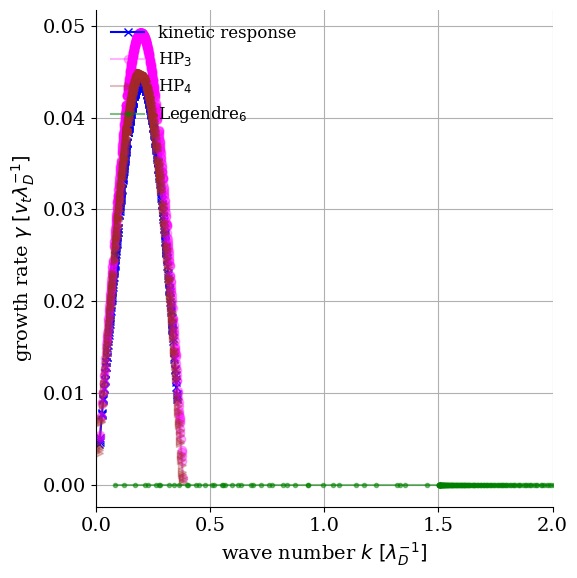

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true*T, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3*T, label=r"HP$_{3}$", c="magenta", marker="o", alpha=0.3)
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4*T, label=r"HP$_{4}$", c="brown", marker=">", alpha=0.3)
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6*T, label=r"Legendre$_{6}$", c="green", marker=".", alpha=0.5)

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
#ax.set_ylim(-1, 0.1)
ax.set_xlim(0., 2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/two_stream_hp.png", dpi=300)

## Bump-on-tail dispersion relation

In [48]:
# Despersion relation
def disp_k_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R(xi=(xi-u2)) - (1-n1)*R(xi=((xi-u1)/T))

# Despersion relation
def disp_k_hp3_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP3(xi=(xi-u2)) - (1-n1)*RHP3(xi=(xi-u1)/T)

# Despersion relation
def disp_k_hp4_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP4(xi=(xi-u2)) -(1-n1)*RHP4(xi=(xi-u1)/T)

# Despersion relation
def disp_k_6_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R6(xi=(xi-u2)) -(1-n1)*R6(xi=(xi-u1)/T)

In [49]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(1E-2, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [50]:
gr_hp3, k_hp3 = get_landau_dispersion(func=disp_k_hp3_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [51]:
gr_hp4, k_hp4 = get_landau_dispersion(func=disp_k_hp4_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [52]:
gr_l16, k_l16 = get_landau_dispersion(func=disp_k_6_bot, xi_real=np.linspace(0, 4, int(1e3)), xi_imag=np.linspace(0, 3, int(1e3)), tol=1e-3)

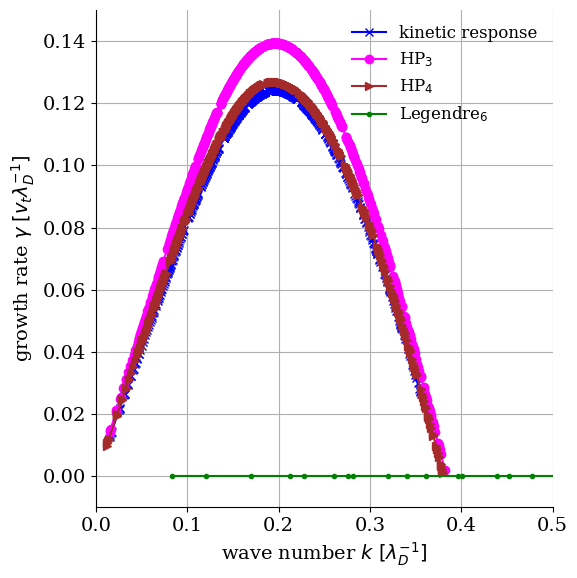

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"HP$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"HP$_{4}$", c="brown", marker=">")
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6, label=r"Legendre$_{6}$", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-0.01, 0.15)
ax.set_xlim(0., 0.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/bump_on_tail_hp.png", dpi=300)